In [116]:
from mxnet import autograd
from mxnet import ndarray as nd
from mxnet import gluon
import pandas as pd
import numpy as np


In [117]:
#导入 取了对数的label

# df_train = pd.read_csv('./input/processed_train_logged.csv')
# df_test = pd.read_csv('./input/processed_test_logged.csv')

#导入没有取对数的label

df_train = pd.read_csv('./input/processed_train_without_log.csv')
df_test = pd.read_csv('./input/processed_test_without_log.csv')

In [118]:
#处理输入数据
target = 'label'
feat_data = df_train[df_train.columns[df_train.columns!='label']]
feat_names = feat_data.dtypes[feat_data.dtypes!=object].index
train_data = nd.array(df_train[feat_names].values)
label = nd.array(df_train['label'].values)
test_data = nd.array(df_test.values)


In [119]:
def get_rmse_log(net, X_train, y_train):
    num_train = X_train.shape[0]
    clipped_preds = nd.clip(net(X_train), 1, float('inf'))
    return np.sqrt(2 * nd.sum(l2loss(
        nd.log(clipped_preds), nd.log(y_train))).asscalar() / num_train)

In [120]:
#使用gluon内置的dataloader

batch_size = 100
def get_net():
    net = gluon.nn.Sequential()
    with net.name_scope():
        net.add(gluon.nn.Dense(1))
    net.initialize()
    return net

In [121]:
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 120
import matplotlib.pyplot as plt

In [122]:
#用一个多层感知机吧
import mxnet.gluon.nn as nn
import mxnet

net = get_net()

# training
epoches = 100
global_train_loss = []
l2loss = gluon.loss.L2Loss()
def train_test(net,verbose_epoches,train_data,train_label,test_data,test_label,learning_rate,wd):
    #kfold
    #net 需要重新初始化
    net.collect_params().initialize(force_reinit=True)
    dataset_train = gluon.data.ArrayDataset(train_data, train_label)
    data_iter_train = gluon.data.DataLoader(dataset_train, batch_size,shuffle=True)
    trainer = gluon.Trainer(net.collect_params(),'adam',{'learning_rate':learning_rate,'wd': wd})
    train_loss = []
    test_loss = []
    for epoch in range(epoches):
        
        rmse = 0.0
        for data,label in data_iter_train:
            with autograd.record():
                output = net(data)
                loss = l2loss(output,label)
            loss.backward()
            trainer.step(batch_size)
            cur_train_loss = get_rmse_log(net,train_data,train_label)
        

        train_loss.append(cur_train_loss)
        cur_test_loss = get_rmse_log(net,test_data,test_label)
#         if(epoch>verbose_epoches):
#             print("Epoch:%d, training rmse:%f , testing rmse:%f"%(epoch,cur_train_loss,cur_test_loss))
        test_loss.append(cur_test_loss)
    plt.plot(train_loss)
#     plt.legend(['train'])
#     plt.plot(test_loss)
#     plt.legend(['train','test'])
    plt.show()
    return cur_train_loss,cur_test_loss
    
    



In [123]:
learning_rate = 5
wd  = 0.1

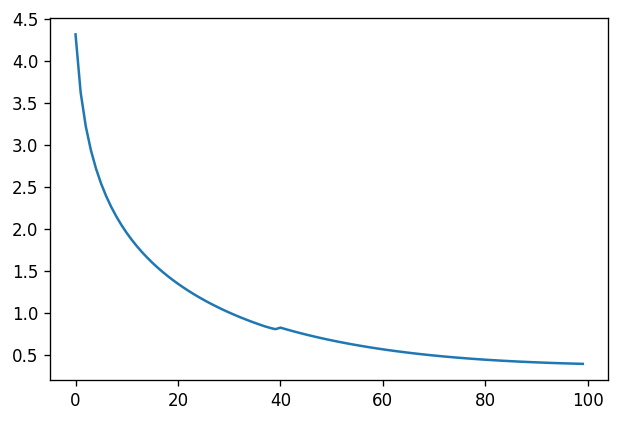

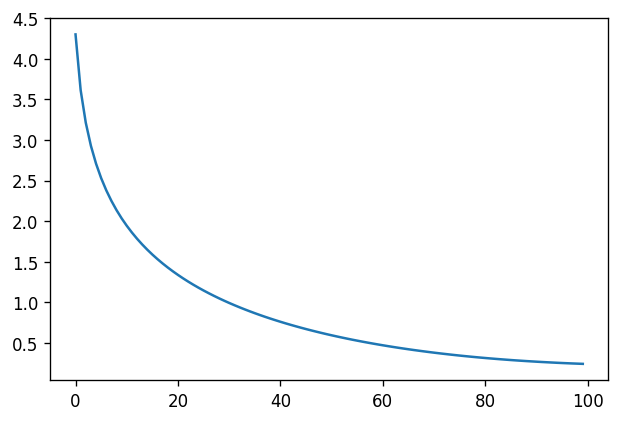

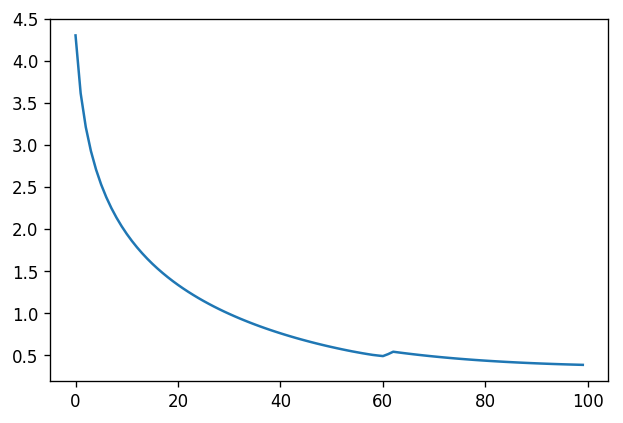

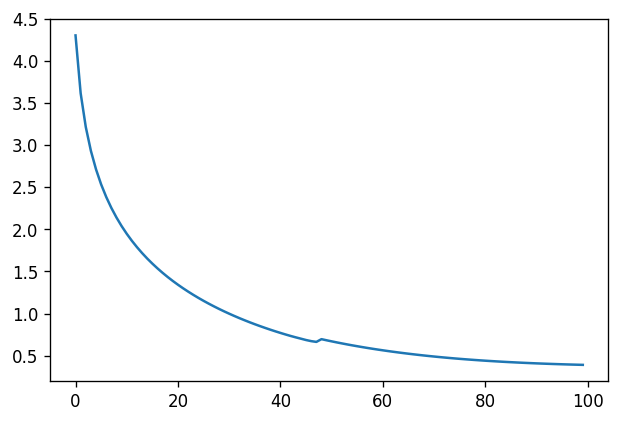

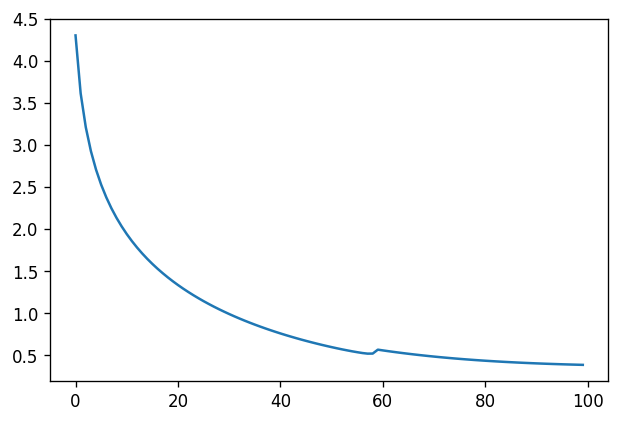

In [124]:
#write k-fold codes
from sklearn.model_selection import KFold

kf = KFold(n_splits=5)
for train_index,test_index in kf.split(train_data):
    train_index= nd.array(train_index)
    test_index = nd.array(test_index)
    train_feat,train_label = nd.take(train_data,train_index),nd.take(label,train_index)
    valid_feat,valid_label = nd.take(train_data,test_index),nd.take(label,test_index)
    train_rmse,valid_rmse = train_test(net,90,train_feat,train_label,valid_feat,valid_label,learning_rate,wd)
#     print(train_rmse)
#     print(valid_rmse)